---
# HBandit validation notebook

This validation notebook compares the behavior of various algorithms implemented in `HBandit`. It leverages the [SMPyBandts](https://github.com/SMPyBandits/SMPyBandits/) experimental MAB framework. Moreover, its contents are adapted from [this](https://github.com/SMPyBandits/SMPyBandits/blob/master/notebooks/Example_of_a_small_Single-Player_Simulation.ipynb) notebook. 

## Preamble
This uses the code from `validation/sharedlib.py` to load the shared library provided with HBandit. The `SHELLSO` environment variable is used to allow this notebook to be consumed both as a [Nix](https://nixos.org)-packaged publishable recipe (where `SHELLSO` points to the *nix store*) and an interactive, `nix-shell`-based artifact (where `SHELLSO` points to a `cabal` shared library build).

In [1]:
import sharedlib, os
hbandit = sharedlib.UnsafeLib(os.environ["SHELLSO"])

The next cell wraps the anytime non-parametric Exp3 bandit from hbandit using SMPyBandit's class-based conventions:

In [2]:
class SMPyExp3(object):
    def __init__(self, nbArms, *args, **kwargs):
        s,a = hbandit.initExp3(nbArms)
        self.state = s 
        self.action = a-1

    def __str__(self):
        return("Exp3(anytime,nonparametric)")

    def startGame(self):
        pass

    def getReward(self, arm, reward):
        loss=1-reward
        s,a = hbandit.stepExp3(self.state,loss)
        self.state = s
        self.action = a-1

    def choice(self):
        return(self.action)

    def handleCollision(self, arm):
        pass 

We can then use the tools from SMPyBandits to setup an experimental evaluation: 

In [3]:
from __future__ import print_function
from SMPyBandits.Environment import Evaluator, tqdm
from SMPyBandits.Arms import Bernoulli
import SMPyBandits.Policies
from IPython.core import page
def myprint(s):
    try:
        print(s['text/plain'])
    except (KeyError, TypeError):
        print(s)
page.page = myprint

HORIZON = 10000
REPETITIONS = 10
N_JOBS = 1

ENVIRONMENTS = [ 
        {  
            "arm_type": Bernoulli,
            "params": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        }
    ]

POLICIES = [
        {
            "archtype": SMPyBandits.Policies.UCBalpha,
            "params": {
                "alpha": 1
            }
        },
        {
            "archtype": SMPyExp3,
            "params": {}
        },
    ]

evaluation = Evaluator({
    "horizon": HORIZON,
    "repetitions": REPETITIONS,
    "n_jobs": N_JOBS,    # = nb of CPU cores
    "verbosity": 6,      # Max joblib verbosity
    "environment": ENVIRONMENTS,
    "policies": POLICIES,
})
for envId, env in tqdm(enumerate(evaluation.envs), desc="Problems"):
    evaluation.startOneEnv(envId, env)

Info: Using the Jupyter notebook version of the tqdm() decorator, tqdm_notebook() ...
Number of policies in this comparison: 2
Time horizon: 10000
Number of repetitions: 10
Sampling rate for plotting, delta_t_plot: 1
Number of jobs for parallelization: 1
Using this dictionary to create a new environment:
 {'arm_type': <class 'SMPyBandits.Arms.Bernoulli.Bernoulli'>, 'params': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}


Creating a new MAB problem ...
  Reading arms of this MAB problem from a dictionnary 'configuration' = {'arm_type': <class 'SMPyBandits.Arms.Bernoulli.Bernoulli'>, 'params': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]} ...
 - with 'arm_type' = <class 'SMPyBandits.Arms.Bernoulli.Bernoulli'>
 - with 'params' = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
 - with 'arms' = [B(0.1), B(0.2), B(0.3), B(0.4), B(0.5), B(0.6), B(0.7), B(0.8), B(0.9)]
 - with 'means' = [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
 - with 'nbArms' = 9
 - with 'maxArm' = 0.9
 - with 'minArm' = 0.1

T



Evaluating environment: MAB(nbArms: 9, arms: [B(0.1), B(0.2), B(0.3), B(0.4), B(0.5), B(0.6), B(0.7), B(0.8), B(0.9)], minArm: 0.1, maxArm: 0.9)
- Adding policy #1 = {'archtype': <class 'SMPyBandits.Policies.UCBalpha.UCBalpha'>, 'params': {'alpha': 1}} ...
  Creating this policy from a dictionnary 'self.cfg['policies'][0]' = {'archtype': <class 'SMPyBandits.Policies.UCBalpha.UCBalpha'>, 'params': {'alpha': 1}} ...
- Adding policy #2 = {'archtype': <class '__main__.SMPyExp3'>, 'params': {}} ...
  Creating this policy from a dictionnary 'self.cfg['policies'][1]' = {'archtype': <class '__main__.SMPyExp3'>, 'params': {}} ...



- Evaluating policy #1/2: UCB($\alpha=1$) ...



Estimated order by the policy UCB($\alpha=1$) after 10000 steps: [2 0 1 3 4 5 6 7 8] ...
  ==> Optimal arm identification: 100.00% (relative success)...
  ==> Mean distance from optimal ordering: 89.51% (relative success)...



- Evaluating policy #2/2: Exp3(anytime,nonparametric) ...


In [4]:
evaluation.nb_break_points

0

In [5]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12.4, 7)
def plotAll(evaluation, envId):
    evaluation.printFinalRanking(envId)
    evaluation.plotRegrets(envId)
    evaluation.plotRegrets(envId, semilogx=True)
    evaluation.plotRegrets(envId, meanReward=True)
    evaluation.plotBestArmPulls(envId)

### First problem


Giving the final ranks ...

Final ranking for this environment #0 : (using less accurate estimate of the regret)
- Policy 'UCB($\alpha=1$)'	was ranked	1 / 2 for this simulation
	(last regret = 107.74,	total regret = 107.9,	total reward = 8900.6,	total weighted selection = 8892.1).
- Policy 'Exp3(anytime,nonparametric)'	was ranked	2 / 2 for this simulation
	(last regret = 145.98,	total regret = 146,	total reward = 8855.7,	total weighted selection = 8854).

This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 7.52 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 48.89% ...


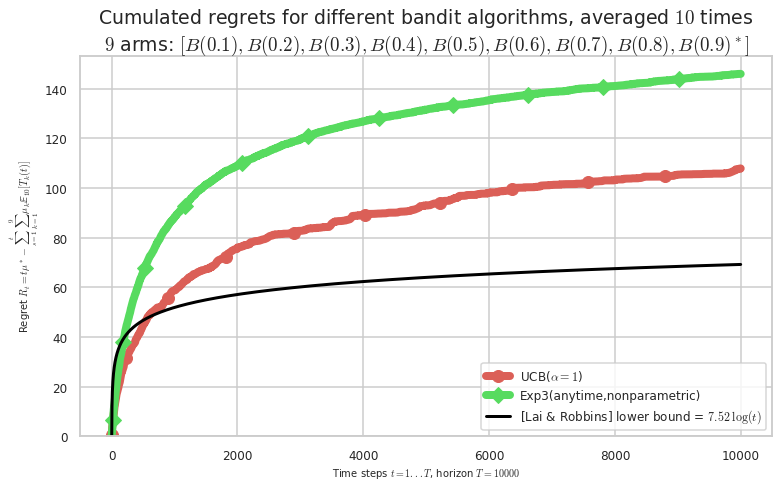

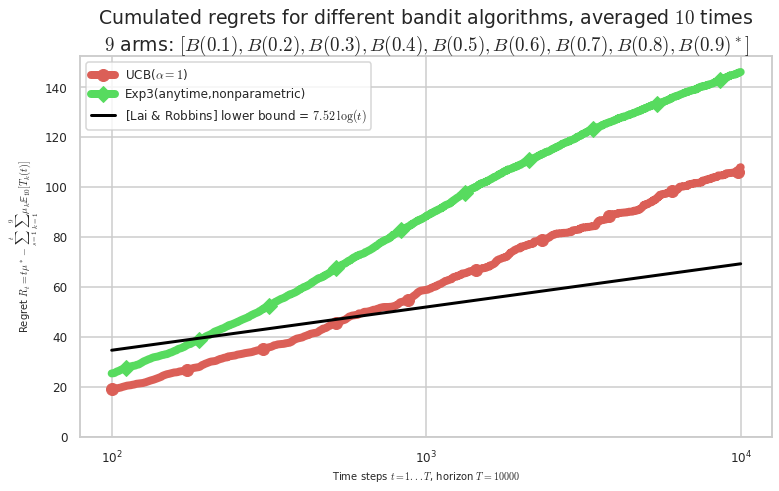


This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 7.52 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 48.89% ...


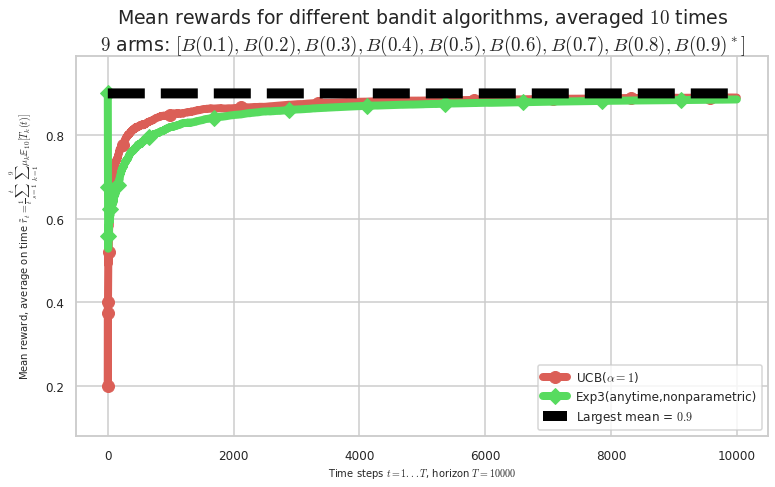

/nix/store/n7jnj5p163p0m1n927zsgbwi7rsl5p1p-python3-3.7.4-env/lib/python3.7/site-packages/SMPyBandits/Environment/plotsettings.py:258: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes().yaxis


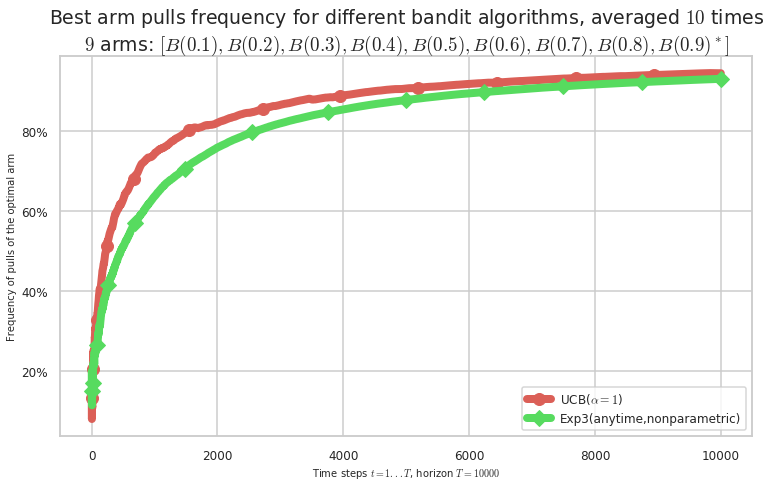

In [6]:
_ = plotAll(evaluation, 0)